In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/Github/"CS 499 - SPRING 2022"/"2. STAN - With commenting"
! pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/2. STAN - With commenting
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/2. STAN - With commenting


In [2]:
! pip install epiweeks
! pip install haversine
! pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 165.0 MB 47 kB/s 


In [3]:
import csv
import os

import numpy as np
import pandas as pd
from epiweeks import Week

from data_downloader import GenerateTrainingData
from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [4]:
# GenerateTrainingData().download_jhu_data('2020-05-01', '2020-12-01')
GenerateTrainingData().download_jhu_data('2020-04-12', '2022-01-24')

Finish download


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases
0,Alabama,32.3182,-86.9023,1,2020-04-15,4307,4,0.0,0.0,0.0,266
0,Alabama,32.3182,-86.9023,1,2020-04-16,4465,15,0.0,0.0,0.0,158
0,Alabama,32.3182,-86.9023,1,2020-04-17,4557,15,0.0,0.0,0.0,92
0,Alabama,32.3182,-86.9023,1,2020-04-18,4788,5,0.0,0.0,0.0,231
0,Alabama,32.3182,-86.9023,1,2020-04-19,4978,4,0.0,0.0,0.0,190
...,...,...,...,...,...,...,...,...,...,...,...
52,Virgin Islands,18.3358,-64.8963,78,2022-01-20,14158,0,0.0,0.0,0.0,130
52,Virgin Islands,18.3358,-64.8963,78,2022-01-21,14301,1,0.0,0.0,0.0,143
52,Virgin Islands,18.3358,-64.8963,78,2022-01-22,14398,1,0.0,0.0,0.0,97
52,Virgin Islands,18.3358,-64.8963,78,2022-01-23,14398,0,0.0,0.0,0.0,0


In [5]:
#Merge population data with downloaded data
raw_data = pickle.load(open('./data/state_covid_data.pickle','rb'))
pop_data = pd.read_csv('./uszips.csv')
pop_data = pop_data.groupby('state_name').agg({'population':'sum', 'density':'mean', 'lat':'mean', 'lng':'mean'}).reset_index()
raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')

In [6]:
# print(pickle.load(open('./data/state_covid_data.pickle','rb')))
# pop_data.groupby('state_name').agg({'population':'sum', 'density':'mean', 'lat':'mean', 'lng':'mean'}).reset_index()
raw_data

,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases,state_name,population,density,lat,lng
0,Alabama,32.3182,-86.9023,1,2020-04-15,4307,4,0.0,0.0,0.0,266,Alabama,4864630,139.010903,32.884042,-86.819800
1,Alabama,32.3182,-86.9023,1,2020-04-16,4465,15,0.0,0.0,0.0,158,Alabama,4864630,139.010903,32.884042,-86.819800
2,Alabama,32.3182,-86.9023,1,2020-04-17,4557,15,0.0,0.0,0.0,92,Alabama,4864630,139.010903,32.884042,-86.819800
3,Alabama,32.3182,-86.9023,1,2020-04-18,4788,5,0.0,0.0,0.0,231,Alabama,4864630,139.010903,32.884042,-86.819800
4,Alabama,32.3182,-86.9023,1,2020-04-19,4978,4,0.0,0.0,0.0,190,Alabama,4864630,139.010903,32.884042,-86.819800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33795,Wyoming,42.7560,-107.3025,56,2022-01-20,133495,0,0.0,0.0,4.0,1350,Wyoming,582091,90.858989,42.932801,-107.378368
33796,Wyoming,42.7560,-107.3025,56,2022-01-21,135369,0,0.0,0.0,4.0,1874,Wyoming,582091,90.858989,42.932801,-107.378368
33797,Wyoming,42.7560,-107.3025,56,2022-01-22,135369,0,0.0,0.0,2.0,0,Wyoming,582091,90.858989,42.932801,-107.378368
33798,Wyoming,42.7560,-107.3025,56,2022-01-23,135369,0,0.0,0.0,0.0,0,Wyoming,582091,90.858989,42.932801,-107.378368


In [7]:
# Generate location similarity
loc_list = list(raw_data['state'].unique())
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = raw_data[raw_data['state']==each_loc]['latitude'].unique()[0]
        lng1 = raw_data[raw_data['state']==each_loc]['longitude'].unique()[0]
        pop1 = raw_data[raw_data['state']==each_loc]['population'].unique()[0]
        
        lat2 = raw_data[raw_data['state']==each_loc2]['latitude'].unique()[0]
        lng2 = raw_data[raw_data['state']==each_loc2]['longitude'].unique()[0]
        pop2 = raw_data[raw_data['state']==each_loc2]['population'].unique()[0]
        
        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)

In [8]:
#Generate Graph
dist_threshold = 18

# Sorts each dictionary in the big loc_dist_map dictionary in descending order of similarity, instead of in increasing alphabetical order 
for each_loc in loc_dist_map:
    loc_dist_map[each_loc] = {k: v for k, v in sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)}
    
adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, each_loc2 in enumerate(loc_dist_map[each_loc]):
        if loc_dist_map[each_loc][each_loc2] > dist_threshold:
            if i <= 3:
                adj_map[each_loc].append(each_loc2)
            else:
                break
        else:
            if i <= 1:
                adj_map[each_loc].append(each_loc2)
            else:
                break

rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        rows.append(loc_list.index(each_loc))
        cols.append(loc_list.index(each_loc2))

In [9]:
g = dgl.graph((rows, cols))

In [10]:
# Code I added to understand what is going on with static_feat
# test_feat = []
# for i, each_loc in enumerate(loc_list):
#     test_feat.append(np.array(raw_data[raw_data['state'] == each_loc][['population','density','lng','lat']]))
# print(len(test_feat[0][0])) # test_feat shape = 52 states x 649 days x 4 columns

# test_feat = np.array(test_feat)[:, 0, :]
# print(test_feat.shape) # 52 states x 4 columns (population, density, lng, lat) 

# print(test_feat[:, 0]) # get population of each state
# print(test_feat[:, 0].shape) # shape = (52,)

# print(np.expand_dims(test_feat[:, 0], -1))
# print(np.expand_dims(test_feat[:, 0], -1).shape) # 52, 1



In [11]:
# Preprocess features

active_cases = []
confirmed_cases = []
new_cases = []
death_cases = []
static_feat = []

for i, each_loc in enumerate(loc_list):
    active_cases.append(raw_data[raw_data['state'] == each_loc]['active'])
    confirmed_cases.append(raw_data[raw_data['state'] == each_loc]['confirmed'])
    new_cases.append(raw_data[raw_data['state'] == each_loc]['new_cases'])
    death_cases.append(raw_data[raw_data['state'] == each_loc]['deaths'])
    static_feat.append(np.array(raw_data[raw_data['state'] == each_loc][['population','density','lng','lat']]))
    
active_cases = np.array(active_cases)
confirmed_cases = np.array(confirmed_cases)
death_cases = np.array(death_cases)
new_cases = np.array(new_cases)
static_feat = np.array(static_feat)[:, 0, :]
recovered_cases = confirmed_cases - active_cases - death_cases
susceptible_cases = np.expand_dims(static_feat[:, 0], -1) - active_cases - recovered_cases

# Batch_feat: new_cases(dI), dR, dS
#dI = np.array(new_cases)
dI = np.concatenate((np.zeros((active_cases.shape[0],1), dtype=np.float32), np.diff(active_cases)), axis=-1)
dR = np.concatenate((np.zeros((recovered_cases.shape[0],1), dtype=np.float32), np.diff(recovered_cases)), axis=-1)
dS = np.concatenate((np.zeros((susceptible_cases.shape[0],1), dtype=np.float32), np.diff(susceptible_cases)), axis=-1)

In [12]:
# active_cases.shape # (52, 649)
# active_cases.shape[0] # 52

# np.zeros((52, 1), dtype=np.float)
# np.zeros((52, 1), dtype=np.float).shape # (52, 1)

print(active_cases)
print(active_cases.shape) # (52, 649)
print()

print(np.diff(active_cases))
print(np.diff(active_cases).shape) # (52, 648)
print()

print(np.concatenate((np.zeros((52, 1), dtype=np.float), np.diff(active_cases)), axis=-1)) # Add an extra column of zeros at the very beginning 
                                                                                           # so that shapes are consistent when adding/subtracting
#   For each day i, we can find that day's number of active cases by indexing active_cases[i], and we can find the difference
#     between that day's active_cases and the NEXT day's active cases by indexing dI[i] = NEXT day's active cases - CURRENT day's active cases

[[   0.    0.    0. ...    0.    0.    0.]
 [ 178.  181.  172. ...    0.    0.    0.]
 [3437. 3627. 3803. ...    0.    0.    0.]
 ...
 [ 481.  493.  536. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [ 157.  146.  155. ...    0.    0.    0.]]
(52, 650)

[[  0.   0.   0. ...   0.   0.   0.]
 [  3.  -9. -14. ...   0.   0.   0.]
 [190. 176. 202. ...   0.   0.   0.]
 ...
 [ 12.  43. -22. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [-11.   9. -54. ...   0.   0.   0.]]
(52, 649)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   3.  -9. ...   0.   0.   0.]
 [  0. 190. 176. ...   0.   0.   0.]
 ...
 [  0.  12.  43. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0. -11.   9. ...   0.   0.   0.]]


In [13]:
# Note for self: this stores a tuple denoting the mean and standard deviation of S, I, R, dS, dI, and dR
#Build normalizer
normalizer = {'S':{}, 'I':{}, 'R':{}, 'dS':{}, 'dI':{}, 'dR':{}}

for i, each_loc in enumerate(loc_list):
    normalizer['S'][each_loc] = (np.mean(susceptible_cases[i]), np.std(susceptible_cases[i]))
    normalizer['I'][each_loc] = (np.mean(active_cases[i]), np.std(active_cases[i]))
    normalizer['R'][each_loc] = (np.mean(recovered_cases[i]), np.std(recovered_cases[i]))
    normalizer['dI'][each_loc] = (np.mean(dI[i]), np.std(dI[i]))
    normalizer['dR'][each_loc] = (np.mean(dR[i]), np.std(dR[i]))
    normalizer['dS'][each_loc] = (np.mean(dS[i]), np.std(dS[i]))

In [14]:
# train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR 
#   = prepare_data(train_feat, <-- "data" <-- dI, dR, dS
#                  active_cases[:, :-valid_window-test_window], <-- "sum_I" 
#                  recovered_cases[:, :-valid_window-test_window], <-- "sum_R"
#                  history_window, <-- "history_window"
#                  pred_window, <-- "pred_window"
#                  slide_step) <-- "slide_step"
def prepare_data(data, sum_I, sum_R, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    n_feat = data.shape[2]
    
    x = [] # (n_loc, history_window * n_feat) where n_feat is dI, dR, and dS from data --> seems to be the actual input to model
    y_I = [] # ? (n_loc, pred_window, 1) from dI in data --> seems to be FUTURE pred_window days of dI data
    y_R = [] # ? (n_loc, pred_window, 1) from dR in data --> seems to be FUTURE pred_window days of dR data
    last_I = [] # ? (n_loc, 1) ?? from sum_I which is active_cases --> single value? --> seems to be current cumulative # active cases at current timestep
    last_R = [] # ? (n_loc, 1) ?? from sum_R which is recovered_cases --> single value? --> seems to be current cumulative # recovered cases at current timestep
    concat_I = [] # ? (n_loc, 1) ?? from dI in data --> single value? --> seems to be current dI value at current timesteep 
    concat_R = [] # ? (n_loc, 1) ?? from dR in data --> single value? --> seems to be current dR value at current timestep
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        x.append(data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
        
        concat_I.append(data[:, i+history_window-1, 0])
        concat_R.append(data[:, i+history_window-1, 1])
        last_I.append(sum_I[:, i+history_window-1])
        last_R.append(sum_R[:, i+history_window-1])

        y_I.append(data[:, i+history_window:i+history_window+pred_window, 0])
        y_R.append(data[:, i+history_window:i+history_window+pred_window, 1])

    # print("x dim0 before transpose: ", len(x))
    # print("x dim1 before transpose: ", len(x[0]))
    # print("x dim2 before transpose: ", len(x[0][0]))
    x = np.array(x, dtype=np.float32).transpose((1, 0, 2)) # Rearranges data locations/dimensions (Ex: x's shape goes from (116, 52, 18) to (52, 116, 18) 
                                                          # for 52 states, 116 timesteps, and 6 (history_window) * 3 (dI, dR, and dS)= 18 days of past data)
    # x dim0 before transpose:  116
    # x dim1 before transpose:  52
    # x dim2 before transpose:  18
    # x.shape after transpose:  (52, 116, 18)
    # print("x.shape after transpose: ", x.shape)
    last_I = np.array(last_I, dtype=np.float32).transpose((1, 0))
    last_R = np.array(last_R, dtype=np.float32).transpose((1, 0))
    concat_I = np.array(concat_I, dtype=np.float32).transpose((1, 0))
    concat_R = np.array(concat_R, dtype=np.float32).transpose((1, 0))
    y_I = np.array(y_I, dtype=np.float32).transpose((1, 0, 2))
    y_R = np.array(y_R, dtype=np.float32).transpose((1, 0, 2))
    return x, last_I, last_R, concat_I, concat_R, y_I, y_R

In [15]:
np.concatenate((np.expand_dims(dI, axis=-1), np.expand_dims(dR, axis=-1), np.expand_dims(dS, axis=-1)), axis=-1).shape

(52, 650, 3)

In [16]:
valid_window = 25
test_window = 25

history_window=6
pred_window=15
slide_step=5

dynamic_feat = np.concatenate((np.expand_dims(dI, axis=-1), np.expand_dims(dR, axis=-1), np.expand_dims(dS, axis=-1)), axis=-1)
    
#Normalize
for i, each_loc in enumerate(loc_list):
    dynamic_feat[i, :, 0] = (dynamic_feat[i, :, 0] - normalizer['dI'][each_loc][0]) / normalizer['dI'][each_loc][1]
    dynamic_feat[i, :, 1] = (dynamic_feat[i, :, 1] - normalizer['dR'][each_loc][0]) / normalizer['dR'][each_loc][1]
    dynamic_feat[i, :, 2] = (dynamic_feat[i, :, 2] - normalizer['dS'][each_loc][0]) / normalizer['dS'][each_loc][1]

dI_mean = []
dI_std = []
dR_mean = []
dR_std = []

for i, each_loc in enumerate(loc_list):
    dI_mean.append(normalizer['dI'][each_loc][0])
    dR_mean.append(normalizer['dR'][each_loc][0])
    dI_std.append(normalizer['dI'][each_loc][1])
    dR_std.append(normalizer['dR'][each_loc][1])

dI_mean = np.array(dI_mean)
dI_std = np.array(dI_std)
dR_mean = np.array(dR_mean)
dR_std = np.array(dR_std)

#Split train-test
train_feat = dynamic_feat[:, :-valid_window-test_window, :]
val_feat = dynamic_feat[:, -valid_window-test_window:-test_window, :]
test_feat = dynamic_feat[:, -test_window:, :]

train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR = prepare_data(train_feat, active_cases[:, :-valid_window-test_window], recovered_cases[:, :-valid_window-test_window], history_window, pred_window, slide_step)
val_x, val_I, val_R, val_cI, val_cR, val_yI, val_yR = prepare_data(val_feat, active_cases[:, -valid_window-test_window:-test_window], recovered_cases[:, -valid_window-test_window:-test_window], history_window, pred_window, slide_step)
test_x, test_I, test_R, test_cI, test_cR, test_yI, test_yR = prepare_data(test_feat, active_cases[:, -test_window:], recovered_cases[:, -test_window:], history_window, pred_window, slide_step)

In [17]:
# Code I wrote to understand function of prepare_data??

# train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR 
#   = prepare_data(train_feat, <-- "data" <-- dI, dR, dS
#                  active_cases[:, :-valid_window-test_window], <-- "sum_I" 
#                  recovered_cases[:, :-valid_window-test_window], <-- "sum_R"
#                  history_window, <-- "history_window"
#                  pred_window, <-- "pred_window"
#                  slide_step) <-- "slide_step"

# def prepare_data(data, sum_I, sum_R, history_window=5, pred_window=15, slide_step=5):
# Data shape n_loc, timestep, n_feat
# Reshape to n_loc, t, history_window*n_feat
temp_data = train_feat
temp_sum_I = active_cases[:, :-valid_window-test_window]
temp_sum_R = recovered_cases[:, :-valid_window-test_window]

# print(temp_data.shape) # (52, 600, 3) <-- 52 states x 600 days of data x 3 values which are dI, dR, dS after normalization
# print(temp_sum_I.shape) # (52, 600) <-- 52 states x 600 days of data each of which is the total? number of active cases that day
# print(temp_sum_R.shape) # (52, 600) <-- 52 states x 600 days of data each of which is the total? number of recovered cases that day 

n_loc = temp_data.shape[0]
timestep = temp_data.shape[1]
n_feat = temp_data.shape[2]

x = [] # ? (n_loc, history_window * n_feat) where n_feat is dI, dR, and dS from data --> seems to be the actual input to model
y_I = [] # ? (n_loc, pred_window, 1) from dI in data --> seems to be FUTURE pred_window days of dI data
y_R = [] # ? (n_loc, pred_window, 1) from dR in data --> seems to be FUTURE pred_window days of dR data
last_I = [] # ? (n_loc, 1) ?? from sum_I which is active_cases --> single value? --> seems to be current cumulative # active cases at current timestep
last_R = [] # ? (n_loc, 1) ?? from sum_R which is recovered_cases --> single value? --> seems to be current cumulative # recovered cases at current timestep
concat_I = [] # ? (n_loc, 1) ?? from dI in data --> single value? --> seems to be current dI value at current timesteep 
concat_R = [] # ? (n_loc, 1) ?? from dR in data --> single value? --> seems to be current dR value at current timestep

# print(x.shape) # (52, 116, 18) <-- 52 states x 116 training examples x 18 items of data (dI, dR, and dS for previous history_window days) per training example
#   NOTE THAT THIS IS X SHAPE AFTER DOING x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
# print(last_I.shape) # (52, 116) <-- 52 states x 116 training examples each of which is the # of total active cases at current time step
# print(last_R.shape) # (52, 116) <-- 52 states x 116 training examples each of which is the # of total recovered cases at current time step
# print(concat_I.shape) # (52, 116) <-- 52 states x 116 training examples each of which is the value of dI at current time step 
# print(concat_R.shape) # (52, 116) <-- 52 states x 116 training examples each of which is the value of dR at current time step
# print(y_I.shape) # (52, 116, 15) <-- 52 states x 116 training examples x 15 days (pred_window) of future dI values 
# print(y_R.shape) # (52, 116, 15) <-- 52 states x 116 training examples x 15 days (pred_window) of future dR values


for i in range(0, timestep, slide_step):
    if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
        break
    x.append(temp_data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
    # Reshapes 
    # [[  |   |   |
    #     dI  dR  dS      into ===> [[ dI_1, dR_1, dS_1, dI_2, dR_2, dS_2, .... dI_6, dR_6, dS_6]]
    #     |   |   |  ]] 
    # 
    # 
    # 
    
    concat_I.append(temp_data[:, i+history_window-1, 0])
    concat_R.append(temp_data[:, i+history_window-1, 1])
    last_I.append(temp_sum_I[:, i+history_window-1])
    last_R.append(temp_sum_R[:, i+history_window-1])

    y_I.append(temp_data[:, i+history_window:i+history_window+pred_window, 0])
    y_R.append(temp_data[:, i+history_window:i+history_window+pred_window, 1])


print(np.array(x).shape) # 116 x 52 x 18
x = np.array(x, dtype=np.float32).transpose((1, 0, 2)) # 
print(np.array(x).shape) # 52 x 116 x 18

print(np.array(last_I).shape) # 116 x 52
last_I = np.array(last_I, dtype=np.float32).transpose((1, 0))
print(last_I.shape) # 52 x 116

print(np.array(last_R).shape) # 116 x 52
last_R = np.array(last_R, dtype=np.float32).transpose((1, 0))
print(last_R.shape) # 52 x 116

print(np.array(concat_I).shape) # 116 x 52
concat_I = np.array(concat_I, dtype=np.float32).transpose((1, 0))
print(concat_I.shape) # 52 x 116

print(np.array(concat_R).shape) # 116 x 52
concat_R = np.array(concat_R, dtype=np.float32).transpose((1, 0))
print(concat_R.shape) # 52 x 116

print(np.array(y_I).shape)
y_I = np.array(y_I, dtype=np.float32).transpose((1, 0, 2))
print(y_I.shape)

print(np.array(y_R).shape) # 116 x 52 x 15
y_R = np.array(y_R, dtype=np.float32).transpose((1, 0, 2))
print(y_R.shape) # 52 x 116 x 15

# return x, last_I, last_R, concat_I, concat_R, y_I, y_R




(116, 52, 18)
(52, 116, 18)
(116, 52)
(52, 116)
(116, 52)
(52, 116)
(116, 52)
(52, 116)
(116, 52)
(52, 116)
(116, 52, 15)
(52, 116, 15)
(116, 52, 15)
(52, 116, 15)


In [18]:
#Build STAN model

in_dim = 3*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g = g.to(device)
model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [19]:
model

STAN(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=18, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_res_I): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_R): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_sir): Linear(in_features=34, out_features=2, bias=True)
)

In [20]:
train_x = torch.tensor(train_x).to(device)
train_I = torch.tensor(train_I).to(device)
train_R = torch.tensor(train_R).to(device)
train_cI = torch.tensor(train_cI).to(device)
train_cR = torch.tensor(train_cR).to(device)
train_yI = torch.tensor(train_yI).to(device)
train_yR = torch.tensor(train_yR).to(device)

val_x = torch.tensor(val_x).to(device)
val_I = torch.tensor(val_I).to(device)
val_R = torch.tensor(val_R).to(device)
val_cI = torch.tensor(val_cI).to(device)
val_cR = torch.tensor(val_cR).to(device)
val_yI = torch.tensor(val_yI).to(device)
val_yR = torch.tensor(val_yR).to(device)

test_x = torch.tensor(test_x).to(device)
test_I = torch.tensor(test_I).to(device)
test_R = torch.tensor(test_R).to(device)
test_cI = torch.tensor(test_cI).to(device)
test_cR = torch.tensor(test_cR).to(device)
test_yI = torch.tensor(test_yI).to(device)
test_yR = torch.tensor(test_yR).to(device)

dI_mean = torch.tensor(dI_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dI_std = torch.tensor(dI_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_mean = torch.tensor(dR_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_std = torch.tensor(dR_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [22]:
print(train_x.shape)
print(train_I.shape)
print(train_R.shape)
print(train_cI.shape)
print(train_cR.shape)
print(train_yI.shape)
print(train_yR.shape)

print("==========================================")
print(val_x.shape)
print(val_I.shape)
print(val_R.shape)
print(val_cI.shape)
print(val_cR.shape)
print(val_yI.shape)
print(val_yR.shape)

print("==========================================")
print(test_x.shape)
print(test_I.shape)
print(test_R.shape)
print(test_cI.shape)
print(test_cR.shape)
print(test_yI.shape)
print(test_yR.shape)

print("==========================================")
print(N.shape)
print(N[0].shape)

torch.Size([52, 116, 18])
torch.Size([52, 116])
torch.Size([52, 116])
torch.Size([52, 116])
torch.Size([52, 116])
torch.Size([52, 116, 15])
torch.Size([52, 116, 15])
torch.Size([52, 1, 18])
torch.Size([52, 1])
torch.Size([52, 1])
torch.Size([52, 1])
torch.Size([52, 1])
torch.Size([52, 1, 15])
torch.Size([52, 1, 15])
torch.Size([52, 1, 18])
torch.Size([52, 1])
torch.Size([52, 1])
torch.Size([52, 1])
torch.Size([52, 1])
torch.Size([52, 1, 15])
torch.Size([52, 1, 15])
torch.Size([52, 1])
torch.Size([1])


In [25]:
# Code I added to understand shape of output with 1 forward pass of STAN

loc_name = 'Kentucky'
cur_loc = loc_list.index(loc_name)

model.eval()
optimizer.zero_grad()

active_pred, recovered_pred, phy_active, phy_recover, hidden_state = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc])
print(active_pred.shape) # Training: (1, 116, 15), Validation/Testing: (1, 1, 15)
print(recovered_pred.shape) # Training: (1, 116, 15), Validation/Testing: (1, 1, 15)
print(phy_active.shape) # Training: (1, 116, 15), Validation/Testing: (1, 1, 15)
print(phy_recover.shape) # Training: (1, 116, 15), Validation/Testing: (1, 1, 15)
print(hidden_state.shape) # Training: (1, 32), Validation/Testing: (1, 32)


torch.Size([1, 1, 15])
torch.Size([1, 1, 15])
torch.Size([1, 1, 15])
torch.Size([1, 1, 15])
torch.Size([1, 32])


In [ ]:
#Train STAN

for loc_name in adj_map.keys():
  print("=====================================================================================")
  print("=====================================================================================")
  print("=====================================================================================")
  print("Training:", loc_name)

  # Copy paste model + optimizer + loss function initialization here to ensure we re-use a different model for each location
  g = g.to(device)
  model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
  criterion = nn.MSELoss()


  all_loss = []
  file_name = './save/state_models' + '/'+ str(loc_name)
  min_loss = 1e10
  # loc_name = 'Kentucky'
  cur_loc = loc_list.index(loc_name)

  for epoch in range(50):
      model.train()
      optimizer.zero_grad()
      
      active_pred, recovered_pred, phy_active, phy_recover, _ = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
      phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
      phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]
      loss = criterion(active_pred.squeeze(), train_yI[cur_loc])+criterion(recovered_pred.squeeze(), train_yR[cur_loc])+0.1*criterion(phy_active.squeeze(), train_yI[cur_loc])+0.1*criterion(phy_recover.squeeze(), train_yR[cur_loc])
      
      loss.backward()
      optimizer.step()
      all_loss.append(loss.item())
      
      model.eval()
      _, _, _, _, prev_h = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
      val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc], prev_h)
      
      val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
      val_loss = criterion(val_active_pred.squeeze(), val_yI[cur_loc]) + 0.1*criterion(val_phy_active.squeeze(), val_yI[cur_loc])
      if val_loss < min_loss:    
          # state = {
          #     'state': model.state_dict(),
          #     'optimizer': optimizer.state_dict(),
          # }
          # torch.save(state, file_name)
          min_loss = val_loss
          # print('Saved best model')
      print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, all_loss[-1], val_loss.item()))

Training: Alabama


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss 4.33, Val loss 0.04
Epoch 1, Loss 32.88, Val loss 0.05
Epoch 2, Loss 40.76, Val loss 0.05
Epoch 3, Loss 31.74, Val loss 0.03
Epoch 4, Loss 15.19, Val loss 0.02
Epoch 5, Loss 5.02, Val loss 0.03
Epoch 6, Loss 2.93, Val loss 0.03
Epoch 7, Loss 2.57, Val loss 0.03
Epoch 8, Loss 2.48, Val loss 0.04
Epoch 9, Loss 2.45, Val loss 0.04
Epoch 10, Loss 2.43, Val loss 0.03
Epoch 11, Loss 2.42, Val loss 0.03
Epoch 12, Loss 2.41, Val loss 0.03
Epoch 13, Loss 2.40, Val loss 0.03
Epoch 14, Loss 2.40, Val loss 0.02
Epoch 15, Loss 2.40, Val loss 0.02
Epoch 16, Loss 2.40, Val loss 0.01
Epoch 17, Loss 2.39, Val loss 0.02
Epoch 18, Loss 2.38, Val loss 0.02
Epoch 19, Loss 2.37, Val loss 0.03
Epoch 20, Loss 2.37, Val loss 0.04
Epoch 21, Loss 2.36, Val loss 0.03
Epoch 22, Loss 2.35, Val loss 0.03
Epoch 23, Loss 2.34, Val loss 0.03
Epoch 24, Loss 2.34, Val loss 0.03
Epoch 25, Loss 2.34, Val loss 0.03
Epoch 26, Loss 2.33, Val loss 0.02
Epoch 27, Loss 2.35, Val loss 0.02
Epoch 28, Loss 2.33, Val l

KeyboardInterrupt: ignored

Estimated beta in SIR model is 0.02
Estimated gamma in SIR model is 0.04


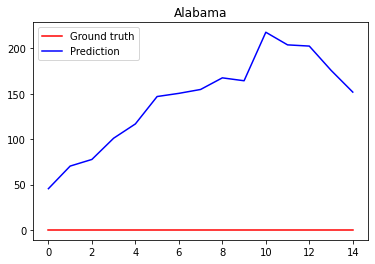

Estimated beta in SIR model is 0.06
Estimated gamma in SIR model is 0.06


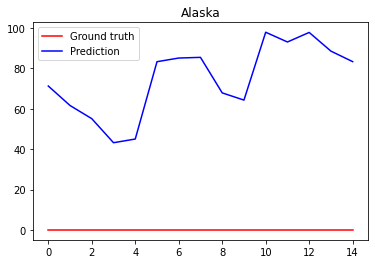

Estimated beta in SIR model is 0.03
Estimated gamma in SIR model is 0.03


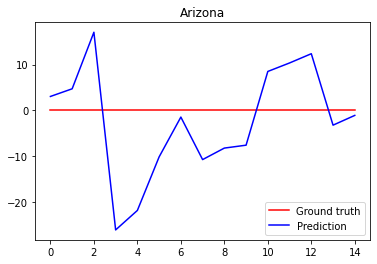

Estimated beta in SIR model is 0.11
Estimated gamma in SIR model is 0.08


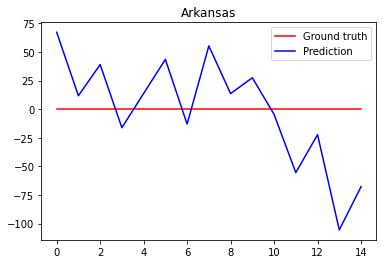

Estimated beta in SIR model is 0.18
Estimated gamma in SIR model is 0.61


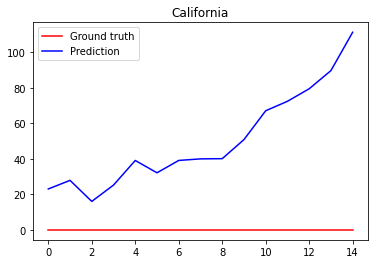

Estimated beta in SIR model is 0.03
Estimated gamma in SIR model is 0.04


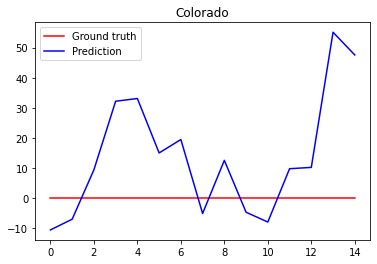

Estimated beta in SIR model is 0.03
Estimated gamma in SIR model is 0.05


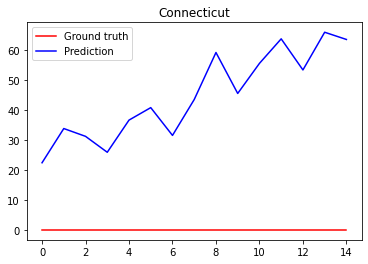

Estimated beta in SIR model is 0.04
Estimated gamma in SIR model is 0.05


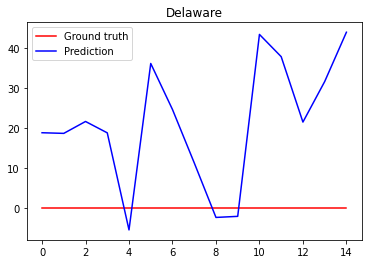

Estimated beta in SIR model is 0.05
Estimated gamma in SIR model is 0.06


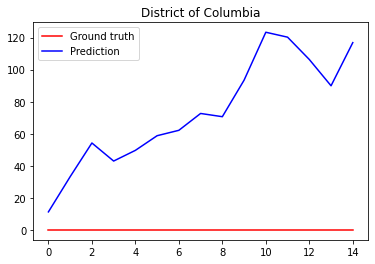

Estimated beta in SIR model is 0.37
Estimated gamma in SIR model is 0.90


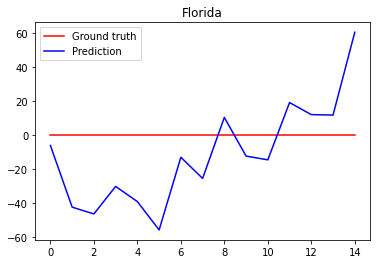

Estimated beta in SIR model is 0.46
Estimated gamma in SIR model is 0.36


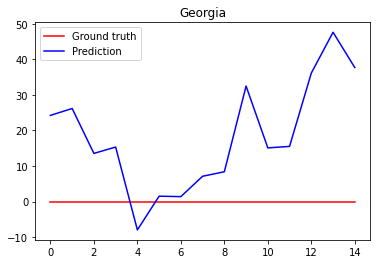

Estimated beta in SIR model is 0.07
Estimated gamma in SIR model is 0.07


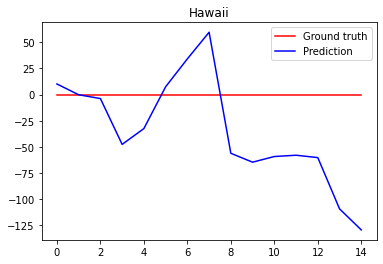

Estimated beta in SIR model is 0.06
Estimated gamma in SIR model is 0.07


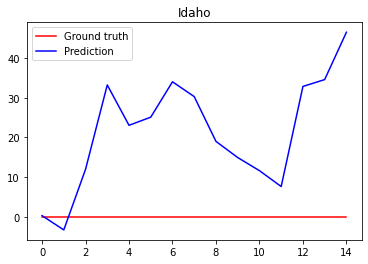

Estimated beta in SIR model is 0.46
Estimated gamma in SIR model is 0.46


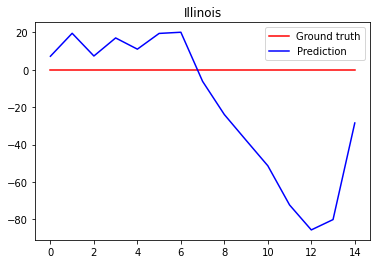

Estimated beta in SIR model is 0.03
Estimated gamma in SIR model is 0.04


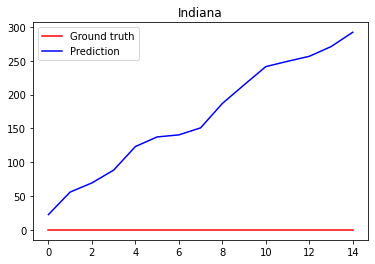

Estimated beta in SIR model is 0.07
Estimated gamma in SIR model is 0.06


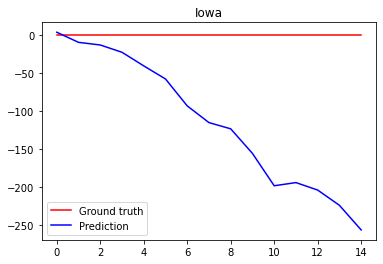

Estimated beta in SIR model is 0.04
Estimated gamma in SIR model is 0.06


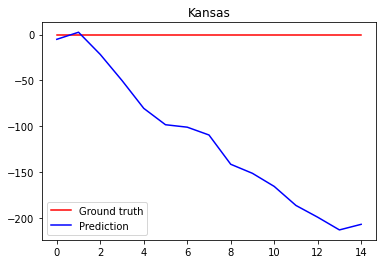

Estimated beta in SIR model is 0.01
Estimated gamma in SIR model is 0.06


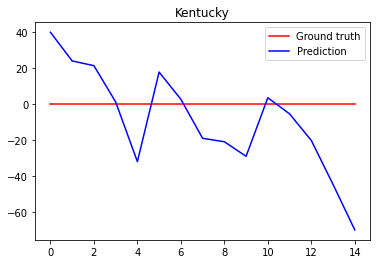

Estimated beta in SIR model is 0.13
Estimated gamma in SIR model is 0.32


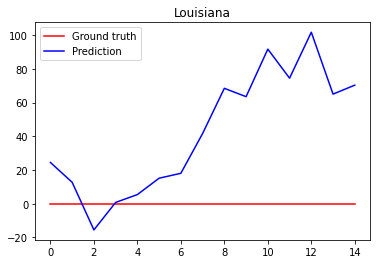

Estimated beta in SIR model is 0.06
Estimated gamma in SIR model is 0.08


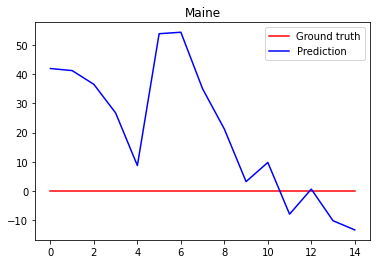

Estimated beta in SIR model is 0.06
Estimated gamma in SIR model is 0.07


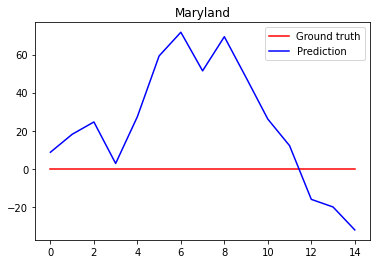

Estimated beta in SIR model is 0.09
Estimated gamma in SIR model is 0.06


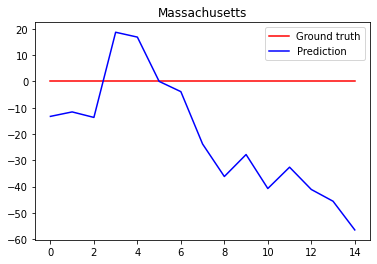

Estimated beta in SIR model is 0.10
Estimated gamma in SIR model is 0.12


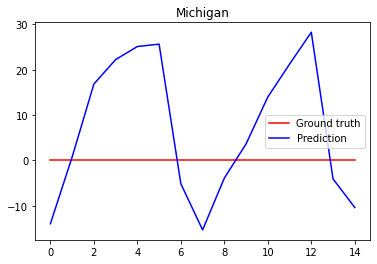

Estimated beta in SIR model is 0.46
Estimated gamma in SIR model is 0.48


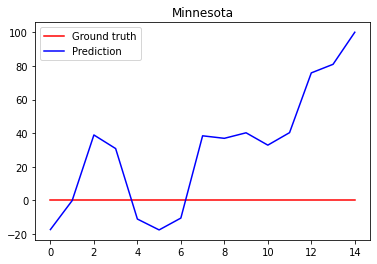

Estimated beta in SIR model is 0.08
Estimated gamma in SIR model is 0.08


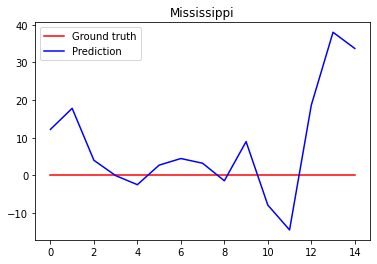

Estimated beta in SIR model is 0.49
Estimated gamma in SIR model is 0.56


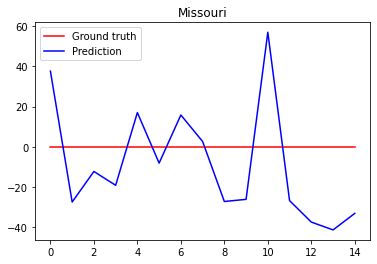

Estimated beta in SIR model is 0.10
Estimated gamma in SIR model is 0.09


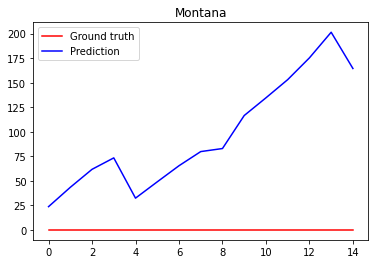

Estimated beta in SIR model is 0.04
Estimated gamma in SIR model is 0.04


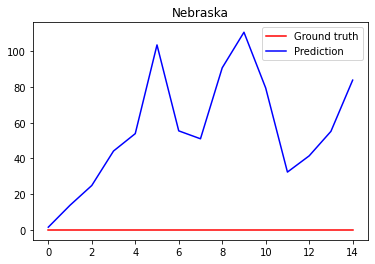

Estimated beta in SIR model is 0.04
Estimated gamma in SIR model is 0.03


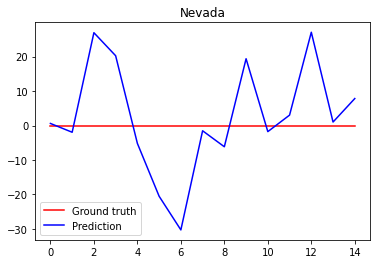

Estimated beta in SIR model is 0.37
Estimated gamma in SIR model is 0.65


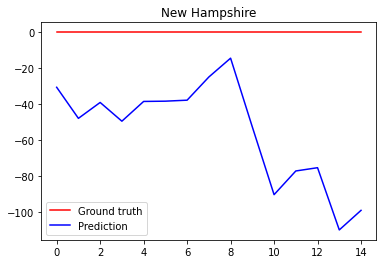

Estimated beta in SIR model is 0.03
Estimated gamma in SIR model is 0.06


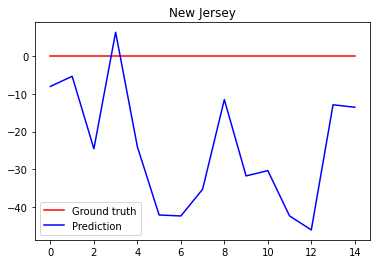

Estimated beta in SIR model is 0.08
Estimated gamma in SIR model is 0.07


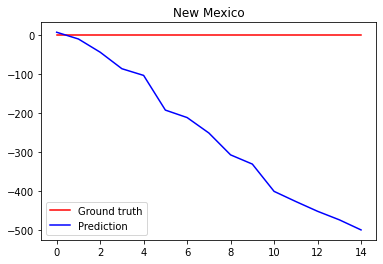

Estimated beta in SIR model is 0.02
Estimated gamma in SIR model is 0.06


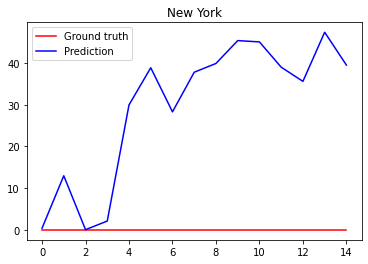

Estimated beta in SIR model is 0.26
Estimated gamma in SIR model is 0.31


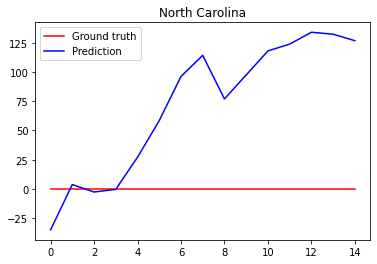

Estimated beta in SIR model is 0.16
Estimated gamma in SIR model is 0.16


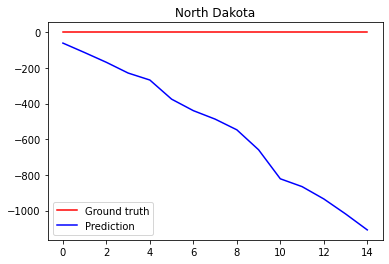

Estimated beta in SIR model is 0.11
Estimated gamma in SIR model is 0.13


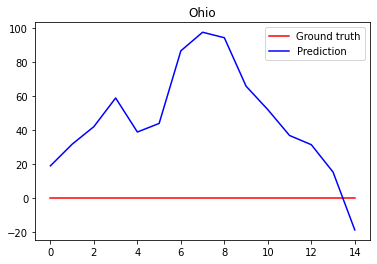

Estimated beta in SIR model is 0.13
Estimated gamma in SIR model is 0.12


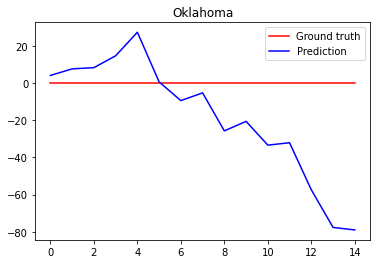

Estimated beta in SIR model is 0.09
Estimated gamma in SIR model is 0.10


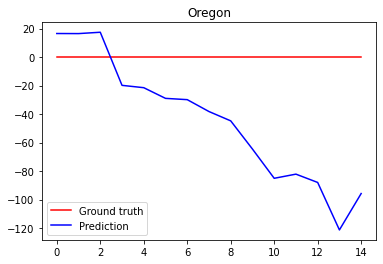

Estimated beta in SIR model is 0.05
Estimated gamma in SIR model is 0.23


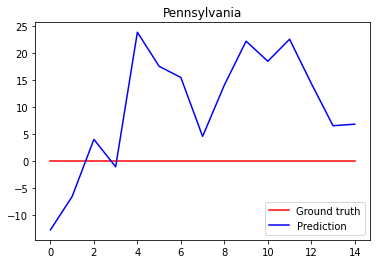

Estimated beta in SIR model is 0.03
Estimated gamma in SIR model is 0.11


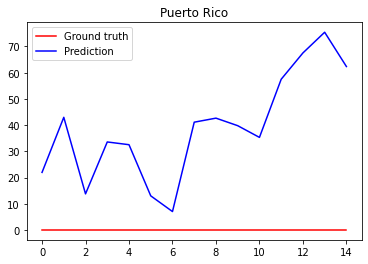

Estimated beta in SIR model is 0.03
Estimated gamma in SIR model is 0.05


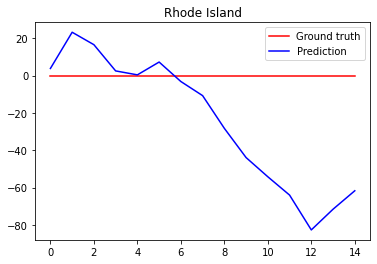

Estimated beta in SIR model is 0.03
Estimated gamma in SIR model is 0.10


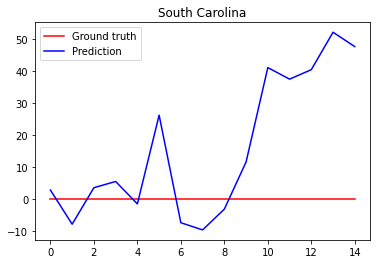

Estimated beta in SIR model is 0.13
Estimated gamma in SIR model is 0.27


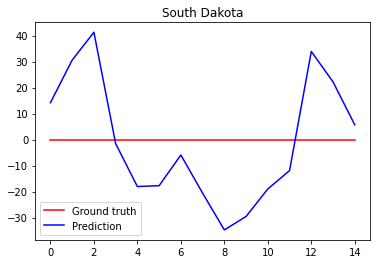

Estimated beta in SIR model is 0.26
Estimated gamma in SIR model is 0.29


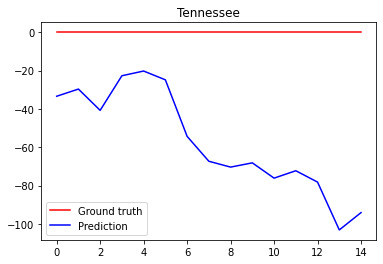

Estimated beta in SIR model is 0.09
Estimated gamma in SIR model is 0.07


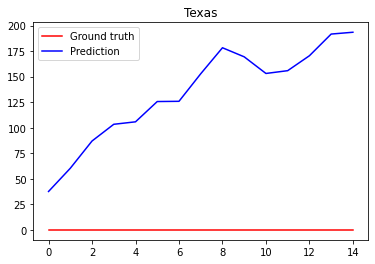

Estimated beta in SIR model is 0.21
Estimated gamma in SIR model is 0.20


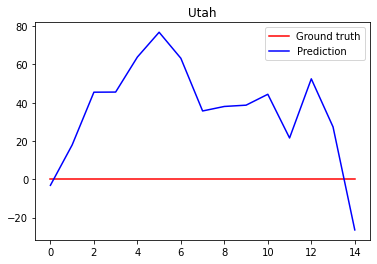

Estimated beta in SIR model is 0.43
Estimated gamma in SIR model is 0.45


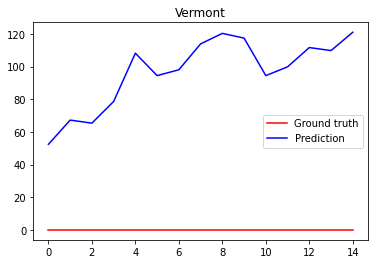

Estimated beta in SIR model is 0.03
Estimated gamma in SIR model is 0.06


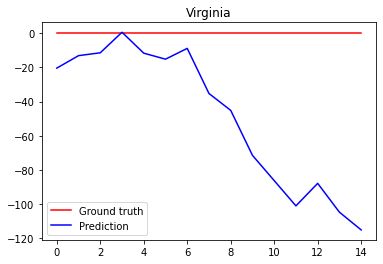

Estimated beta in SIR model is 0.32
Estimated gamma in SIR model is 0.48


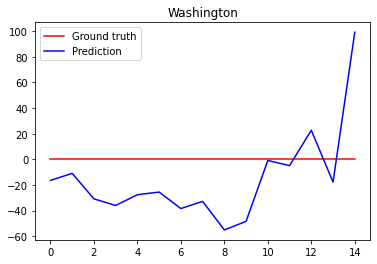

Estimated beta in SIR model is 0.12
Estimated gamma in SIR model is 0.13


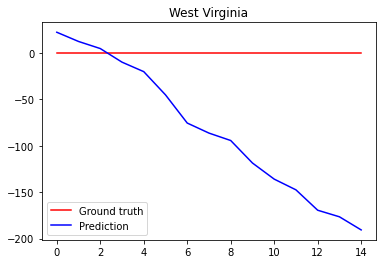

Estimated beta in SIR model is 0.11
Estimated gamma in SIR model is 0.11


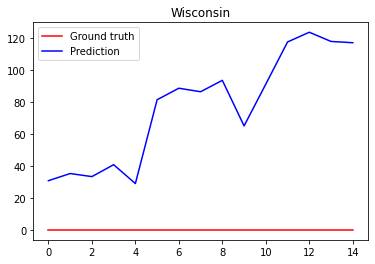

Estimated beta in SIR model is 0.18
Estimated gamma in SIR model is 0.30


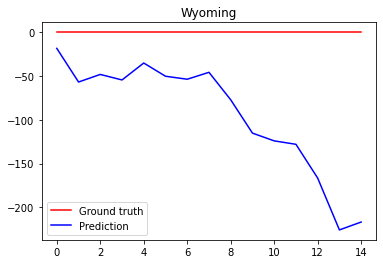

In [ ]:
#Pred with STAN

state_predictions = {}


for loc_name in adj_map.keys():
  file_name = './save/state_models/' + str(loc_name)
  checkpoint = torch.load(file_name)
  model.load_state_dict(checkpoint['state'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  model.eval()


  prev_x = torch.cat((train_x, val_x), dim=1)
  prev_I = torch.cat((train_I, val_I), dim=1)
  prev_R = torch.cat((train_R, val_R), dim=1)
  prev_cI = torch.cat((train_cI, val_cI), dim=1)
  prev_cR = torch.cat((train_cR, val_cR), dim=1)
  prev_active_pred, _, prev_phyactive_pred, _, h = model(prev_x, prev_cI[cur_loc], prev_cR[cur_loc], N[cur_loc], prev_I[cur_loc], prev_R[cur_loc])


  test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(test_x, test_cI[cur_loc], test_cR[cur_loc], N[cur_loc], test_I[cur_loc], test_R[cur_loc], h)

  print('Estimated beta in SIR model is %.2f'%model.alpha_scaled)
  print('Estimated gamma in SIR model is %.2f'%model.beta_scaled)

  #Cumulate predicted dI
  pred_I = []

  # print(test_pred_active.size())

  for i in range(test_pred_active.size(1)):
      cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
      #cur_pred = test_pred_phy_active[0, i, :].detach().cpu().numpy()
      cur_pred = (cur_pred + test_pred_phy_active[0, i, :].detach().cpu().numpy()) / 2
      cur_pred = np.cumsum(cur_pred)
      cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
      pred_I.append(cur_pred)
  pred_I = np.array(pred_I)
  pred_I = pred_I

  def get_real_y(data, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    
    y = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        y.append(data[:, i+history_window:i+history_window+pred_window])
    y = np.array(y, dtype=np.float32).transpose((1, 0, 2))
    return y

  I_true = get_real_y(active_cases[:], history_window, pred_window, slide_step)

  plt.plot(I_true[cur_loc, -1, :],c='r', label='Ground truth')
  plt.plot(pred_I[-1, :],c='b', label='Prediction')
  plt.legend()
  plt.title(loc_name)
  plt.show()


  state_predictions[loc_name] = pred_I

In [ ]:
# Save "state_predictions" dictionary to pickle in case there is problems with running the next cell
filehandler = open("./data/prediction_active_cases.pickle", 'wb') 
pickle.dump(state_predictions, filehandler)
        

In [ ]:
# # Read in data
# state_predictions = pickle.load(open('./data/prediction_active_cases.pickle','rb'))

In [ ]:
###############################################################################################################3
###############################################################################################################3
###############################################################################################################3
###############################################################################################################3
###############################################################################################################3
###############################################################################################################3
###############################################################################################################3
###############################################################################################################3
###############################################################################################################3
###############################################################################################################3
###############################################################################################################3
###############################################################################################################3
# Code added to save output numbers to a csv with columns: active_cases,date_today,state
# Source: https://www.pythontutorial.net/python-basics/python-write-csv-file/
import csv
from datetime import date, timedelta

num_states_to_save = len(state_predictions.keys())
num_days_to_save = state_predictions['Alabama'].shape[1]

f = open('JHU-STAN-Predictions.csv', 'w') # open file in write mode

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
# writer.writerow(['new_cases', 'date_today', 'state'])
writer.writerow(['active_cases', 'date_today', 'state'])

for curr_state in state_predictions.keys():
  for j in range(num_days_to_save):
    # curr_date = str(date.today() + timedelta(hours=24*j))
    curr_date = str(date(2022,1,24) + timedelta(hours=24*j))
    
    # print(curr_state)
    # print(j)
    num_active_cases = state_predictions[curr_state][0][j]
    writer.writerow([num_active_cases, curr_date, curr_state])

# close the file
f.close()

In [ ]:
# Code added to convert full state name to abbreviation
# Used https://gist.github.com/rogerallen/1583593
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

df = pd.read_csv('JHU-STAN-Predictions.csv')

print(df)

for full_state_name in us_state_to_abbrev.keys():
  state_abbrev = us_state_to_abbrev[full_state_name]
  if len(df[df.state == full_state_name]) != 0:
    df = df.replace(to_replace=full_state_name, value=state_abbrev)

print(df)

df.to_csv('JHU-STAN-Predictions.csv')

     active_cases  date_today    state
0       45.409496  2022-01-24  Alabama
1       70.289790  2022-01-25  Alabama
2       77.595170  2022-01-26  Alabama
3      100.967070  2022-01-27  Alabama
4      116.700990  2022-01-28  Alabama
..            ...         ...      ...
775   -124.034790  2022-02-03  Wyoming
776   -127.944010  2022-02-04  Wyoming
777   -166.521290  2022-02-05  Wyoming
778   -225.706500  2022-02-06  Wyoming
779   -216.702730  2022-02-07  Wyoming

[780 rows x 3 columns]
     active_cases  date_today state
0       45.409496  2022-01-24    AL
1       70.289790  2022-01-25    AL
2       77.595170  2022-01-26    AL
3      100.967070  2022-01-27    AL
4      116.700990  2022-01-28    AL
..            ...         ...   ...
775   -124.034790  2022-02-03    WY
776   -127.944010  2022-02-04    WY
777   -166.521290  2022-02-05    WY
778   -225.706500  2022-02-06    WY
779   -216.702730  2022-02-07    WY

[780 rows x 3 columns]
